## Data prep

* original_embeddings: 1854 concepts * 49 features (euclidean)
* memorability scores
* category mappings: 1324 concepts in 27 higher-level categories
* feature names
* typicality scores: average similarity of 1619 concepts within category


In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.linalg import orthogonal_procrustes
import statsmodels.api as sm
import scipy.stats as stats
from hyperbolicMDS.mds import HyperMDS, cart_to_polar
from matplotlib import colors
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import re, seaborn as sns

data_dir = '../data'
output_dir = '../outputs'

In [2]:
# load original 1854*49 embeddings
original_embeddings = np.loadtxt(os.path.join(data_dir, 'spose_embedding_49d_sorted.txt'))
original_embeddings.shape

(1854, 49)

In [3]:
# load categories and memorability score of each concept
cat_mapping = pd.read_csv(os.path.join(data_dir, 'THINGS_Table.csv'))
cat_concept_mem = cat_mapping[['cr', 'smallcat', 'bigcat']].groupby('smallcat').mean()
cat_concept_mem['bigcat'] = cat_concept_mem['bigcat'].astype(int).replace(0, 99)
cat_concept_mem

,cr,bigcat
smallcat,,
1,0.779739,1
2,0.798485,13
3,0.752845,18
4,0.761851,99
5,0.794466,9
...,...,...
1850,0.722655,99
1851,0.843158,10
1852,0.800163,1


In [4]:
### load category names and merge with concepts
cat = loadmat(os.path.join(data_dir,'categories.mat'))
cat_names = [item[0] for item in cat['categories'][0]]
cat_names.append('na')
cat_names = pd.DataFrame(cat_names, columns=['cat_name']).reset_index()
cat_names['index'] = cat_names['index']+1
cat_names.iloc[27] = [99, np.nan]
cat_concept_mem = cat_concept_mem.merge(cat_names, how='left', left_on='bigcat', right_on='index').drop(columns=['index'])
cat_concept_mem


,cr,bigcat,cat_name
0,0.779739,1,animal
1,0.798485,13,home decor
2,0.752845,18,musical instrument
3,0.761851,99,NaN
4,0.794466,9,electronic device
...,...,...,...
1849,0.722655,99,NaN
1850,0.843158,10,food
1851,0.800163,1,animal
1852,0.797468,99,NaN


In [5]:
### load feature names
feat_short = loadmat(os.path.join(data_dir, 'labels_short.mat'))
feat_short_names = [item[0] for item in feat_short['labels_short'][0]]
features = loadmat(os.path.join(data_dir, 'labels.mat'))
feat_name = [item[0][0] for item in features['labels']]
feat_name

['made of metal / artificial / hard',
 'food-related / eating-related / kitchen-related',
 'animal-related / organic',
 'clothing-related / fabric / covering',
 'furniture-related / household-related / artifact',
 'plant-related / green',
 'outdoors-related',
 'transportation / motorized / dynamic',
 'wood-related / brownish',
 'body part-related',
 'colorful',
 'valuable / special occasion-related',
 'electronic / technology',
 'sport-related / recreational activity-related',
 'disc-shaped / round',
 'tool-related',
 'many small things / course pattern',
 'paper-related / thin / flat / text-related',
 'fluid-related / drink-related',
 'long / thin',
 'water-related / blue',
 'powdery / fine-scale pattern',
 'red',
 'feminine (stereotypically) / decorative',
 'bathroom-related / sanitary',
 'black / noble',
 'weapon / danger-related / violence',
 'musical instrument-related / noise-related',
 'sky-related / flying-related / floating-related',
 'spherical / ellipsoid / rounded / volumin

In [6]:
### load typicality score and merge with concepts
cat_typicality = loadmat(os.path.join(data_dir, 'typicality_data27.mat'))
concept_idx = []
concept_typ = []
concept_cat = []
for cat_idx in range(27):
    concept_idx.extend(pd.DataFrame(cat_typicality['category27_ind'][0][cat_idx])[0].to_list())
    concept_typ.extend(pd.DataFrame(cat_typicality['category27_typicality_rating_normed'][cat_idx][0])[0].to_list())
    concept_cat.extend([cat_idx+1 for i in range(len(cat_typicality['category27_ind'][0][cat_idx]))])
concept_typicality_rated = pd.DataFrame({'cat': concept_cat, 'concept': concept_idx, 'typicality': concept_typ})
concept_typicality_rated['concept'] = concept_typicality_rated['concept']-1
concept_typicality_rated

,cat,concept,typicality
0,1,0,4.874352
1,1,12,6.374555
2,1,15,5.342846
3,1,24,4.655669
4,1,25,5.288886
...,...,...,...
1614,27,1602,7.456293
1615,27,1620,5.922099
1616,27,1684,5.219242
1617,27,1712,3.238293


## 49-dim Feature Space

1. Get 49-dim feature embeddings from albatross results (.npy)
2. Get loadings of 1854 concepts in 49-dim hyperbolic feature space
3. Euclidean vs. mobius vector addition: test out different values of S
4. Get average 49-dim feature space embeddings and 1854 concept loadings through procrustes
5. Analysis: predicting memorability (euclidean vs. mobius)
    * Cartesian coordinates (x, y, z: which axis explains variances in memorability the best)
    * Polar coordinates (r, theta, rho: which angle explains the best)
    * Radius (concepts closer to the core vs. on surface are more memorable?)
    * K-Means clusters:
      - Cartesian coordinates
      - Polar coordinates
6. Analysis: with typicality (euclidean vs. mobius)
    * Calculate typicality: average similarity of each concept pair within category 
    * Predicting typicality
      - Cartesian coordinates
      - Polar coordinates 
      - Radius
    * Predicting memorability
      - Typicality (more prototypical --> more memorable?)
      - Typicality + coordinates/radius to predict memorability
        



In [7]:
# 49-dim feature space embeddings
feature_embeddings = np.load(os.path.join(data_dir, 'membatross_embeddings.npy'))
feature_embeddings.shape

(49, 3, 500)

1. `feature_embeddings`: output of ALBATROSS, embbeddings of 49 features that represent where 49 features locate in the 3D hyperbolic space. 
2. By multiplying `original_embeddings` (representations of 1854 concepts in 49-dim euclidean feature space) with `feature_embeddings`, we got `concept_in_feat_coord` that contains the loadings of 1854 concepts in hyperbolic space.
3. Instead of euclidean matrix multiplication (sum of loading * each feature vector), we used einstein scalar multiplication and mobius gyrovetor addition to transform 1854 concepts loadings from 49 feature dimensional space to 3d hyperbolic space. By doing this, loadings on each feature vector were multiplied and added in hyperbolic way, where the parameter S controlled the maximum length of vector (max radius of hyperbolic space).

In [8]:
### mobius addition on vectors
def mobius_addition(concept_loading_on_features, feature_embedding, s):
    # loading: 1854*49, embedding: 49*3
    feature_embedding_norms = np.sqrt((feature_embedding**2).sum(1))
    coordinates = []
    for i in range(concept_loading_on_features.shape[0]): # loop through each concept
        # first load the concept onto the features via r {\displaystyle \otimes }\otimes v = s tanh(r tanh−1(|v|/s))v/|v|
        # this is einstein scalar multiplication
        loaded_features = ((s * np.tanh(concept_loading_on_features[i] * np.arctanh(feature_embedding_norms / s)).reshape(-1, 1) * feature_embedding).T / feature_embedding_norms).T
        loaded_norms = np.sqrt((loaded_features**2).sum(1))
        # sort them and lets go through them in sorted order since the addition is
        # associative but not commutative
        order = np.argsort(loaded_norms)
        u = None
        for j in range(len(order)-1):
            # we don't want to have any vectors on the boundary on the left since
            # then we just get back the original vector
            u_tmp = u if u is not None else loaded_features[order[j],:]
            u_tmp_norm = np.sqrt((u_tmp**2).sum())
            v_tmp = loaded_features[order[j+1]]
            v_tmp_norm = np.sqrt((v_tmp**2).sum())
            if u_tmp_norm > v_tmp_norm:
                v = u_tmp
                v_norm = u_tmp_norm
                u = v_tmp
                u_norm = v_tmp_norm
            else:
                u = u_tmp
                u_norm = u_tmp_norm
                v = v_tmp
                v_norm = v_tmp_norm
            # the mobius gyrovector addition
            u = ((1 +2/s**2 * u@v + v_norm**2/s**2)*u + (1-u_norm**2/s**2)*v)/\
                (1 +2/s**2 * u@v + v_norm**2/s**4*u_norm**2)
        coordinates.append(u)
    return np.vstack(coordinates)

In [9]:
### normalize embeddings and transform concept embeddings to loadings in hyperbolic feature space
concept_in_feat_coord = []
normalized_embeddings = (original_embeddings.T/np.sqrt((original_embeddings**2).sum(axis=1))).T
for layer in range(feature_embeddings.shape[-1]):
    concept_in_feat_coord.append(normalized_embeddings@feature_embeddings[:,:,layer])
#     concept_in_feat_coord.append(mobius_addition(normalized_embeddings, feature_embeddings[:,:,layer], 48))
np.array(concept_in_feat_coord).shape

(500, 1854, 3)

Orthogonal procrustes looped through each layer and rotated them so that all layers mapped closely mapped. 

In [10]:
### procrustes of concept loadings in hyperbolic feature space
concept_in_feat_reference = concept_in_feat_coord[0]
concept_in_feat_output = [concept_in_feat_reference]
for i in range(1, len(concept_in_feat_coord)):
    R, scale = orthogonal_procrustes(concept_in_feat_coord[i], concept_in_feat_reference)
    concept_in_feat_output.append(concept_in_feat_coord[i]@R)
concept_in_feat_reference

array([[ -8.50796008,   4.06421417, -14.14677464],
       [-27.49406584,   8.97765114,   9.93112566],
       [-22.53874525,  25.13829916,  12.92493627],
       ...,
       [-16.87663121,  12.38163867, -10.87102044],
       [ -5.62744744,   8.8857026 ,  12.50605139],
       [-14.71606581,   2.88349557,  -7.40970974]])

In [11]:
### procrustes of feature embeddings
feature_embed_reference = feature_embeddings[:,:,0]
feature_embed_output = [feature_embed_reference]
for i in range(1, feature_embeddings.shape[-1]):
    R, scale = orthogonal_procrustes(feature_embeddings[:,:,i], feature_embed_reference)
#     print(rotated)
    feature_embed_output.append(feature_embeddings[:,:,i]@R)

In [12]:
### average across 500 layers
mean_concept_in_feat = np.array(concept_in_feat_output).mean(axis=0)
mean_feature_embed = np.array(feature_embed_output).mean(0)

In [13]:
### merge concept loadings with category and memorability
mean_concept_in_feat_cat = pd.DataFrame(mean_concept_in_feat).reset_index().merge(cat_concept_mem, how='left', left_on='index', right_index=True)
mean_concept_in_feat_cat_na = mean_concept_in_feat_cat.dropna()
mean_concept_in_feat_cat_na

,index,0,1,2,cr,bigcat,cat_name
0,0,-8.362256,5.447828,-8.557188,0.779739,1,animal
1,1,-26.123590,12.240625,0.518939,0.798485,13,home decor
2,2,-24.385152,14.180849,0.693800,0.752845,18,musical instrument
4,4,-20.330699,11.947785,-4.992442,0.794466,9,electronic device
5,5,-24.493047,16.661652,-4.482670,0.806000,12,furniture
...,...,...,...,...,...,...,...
1847,1847,-18.208906,9.885611,3.776987,0.803129,24,toy
1848,1848,-19.281246,4.272460,-1.785376,0.765881,10,food
1850,1850,-19.551059,2.813812,-2.150868,0.843158,10,food
1851,1851,-14.748351,9.486465,-8.609210,0.800163,1,animal


<IPython.core.display.Javascript object>


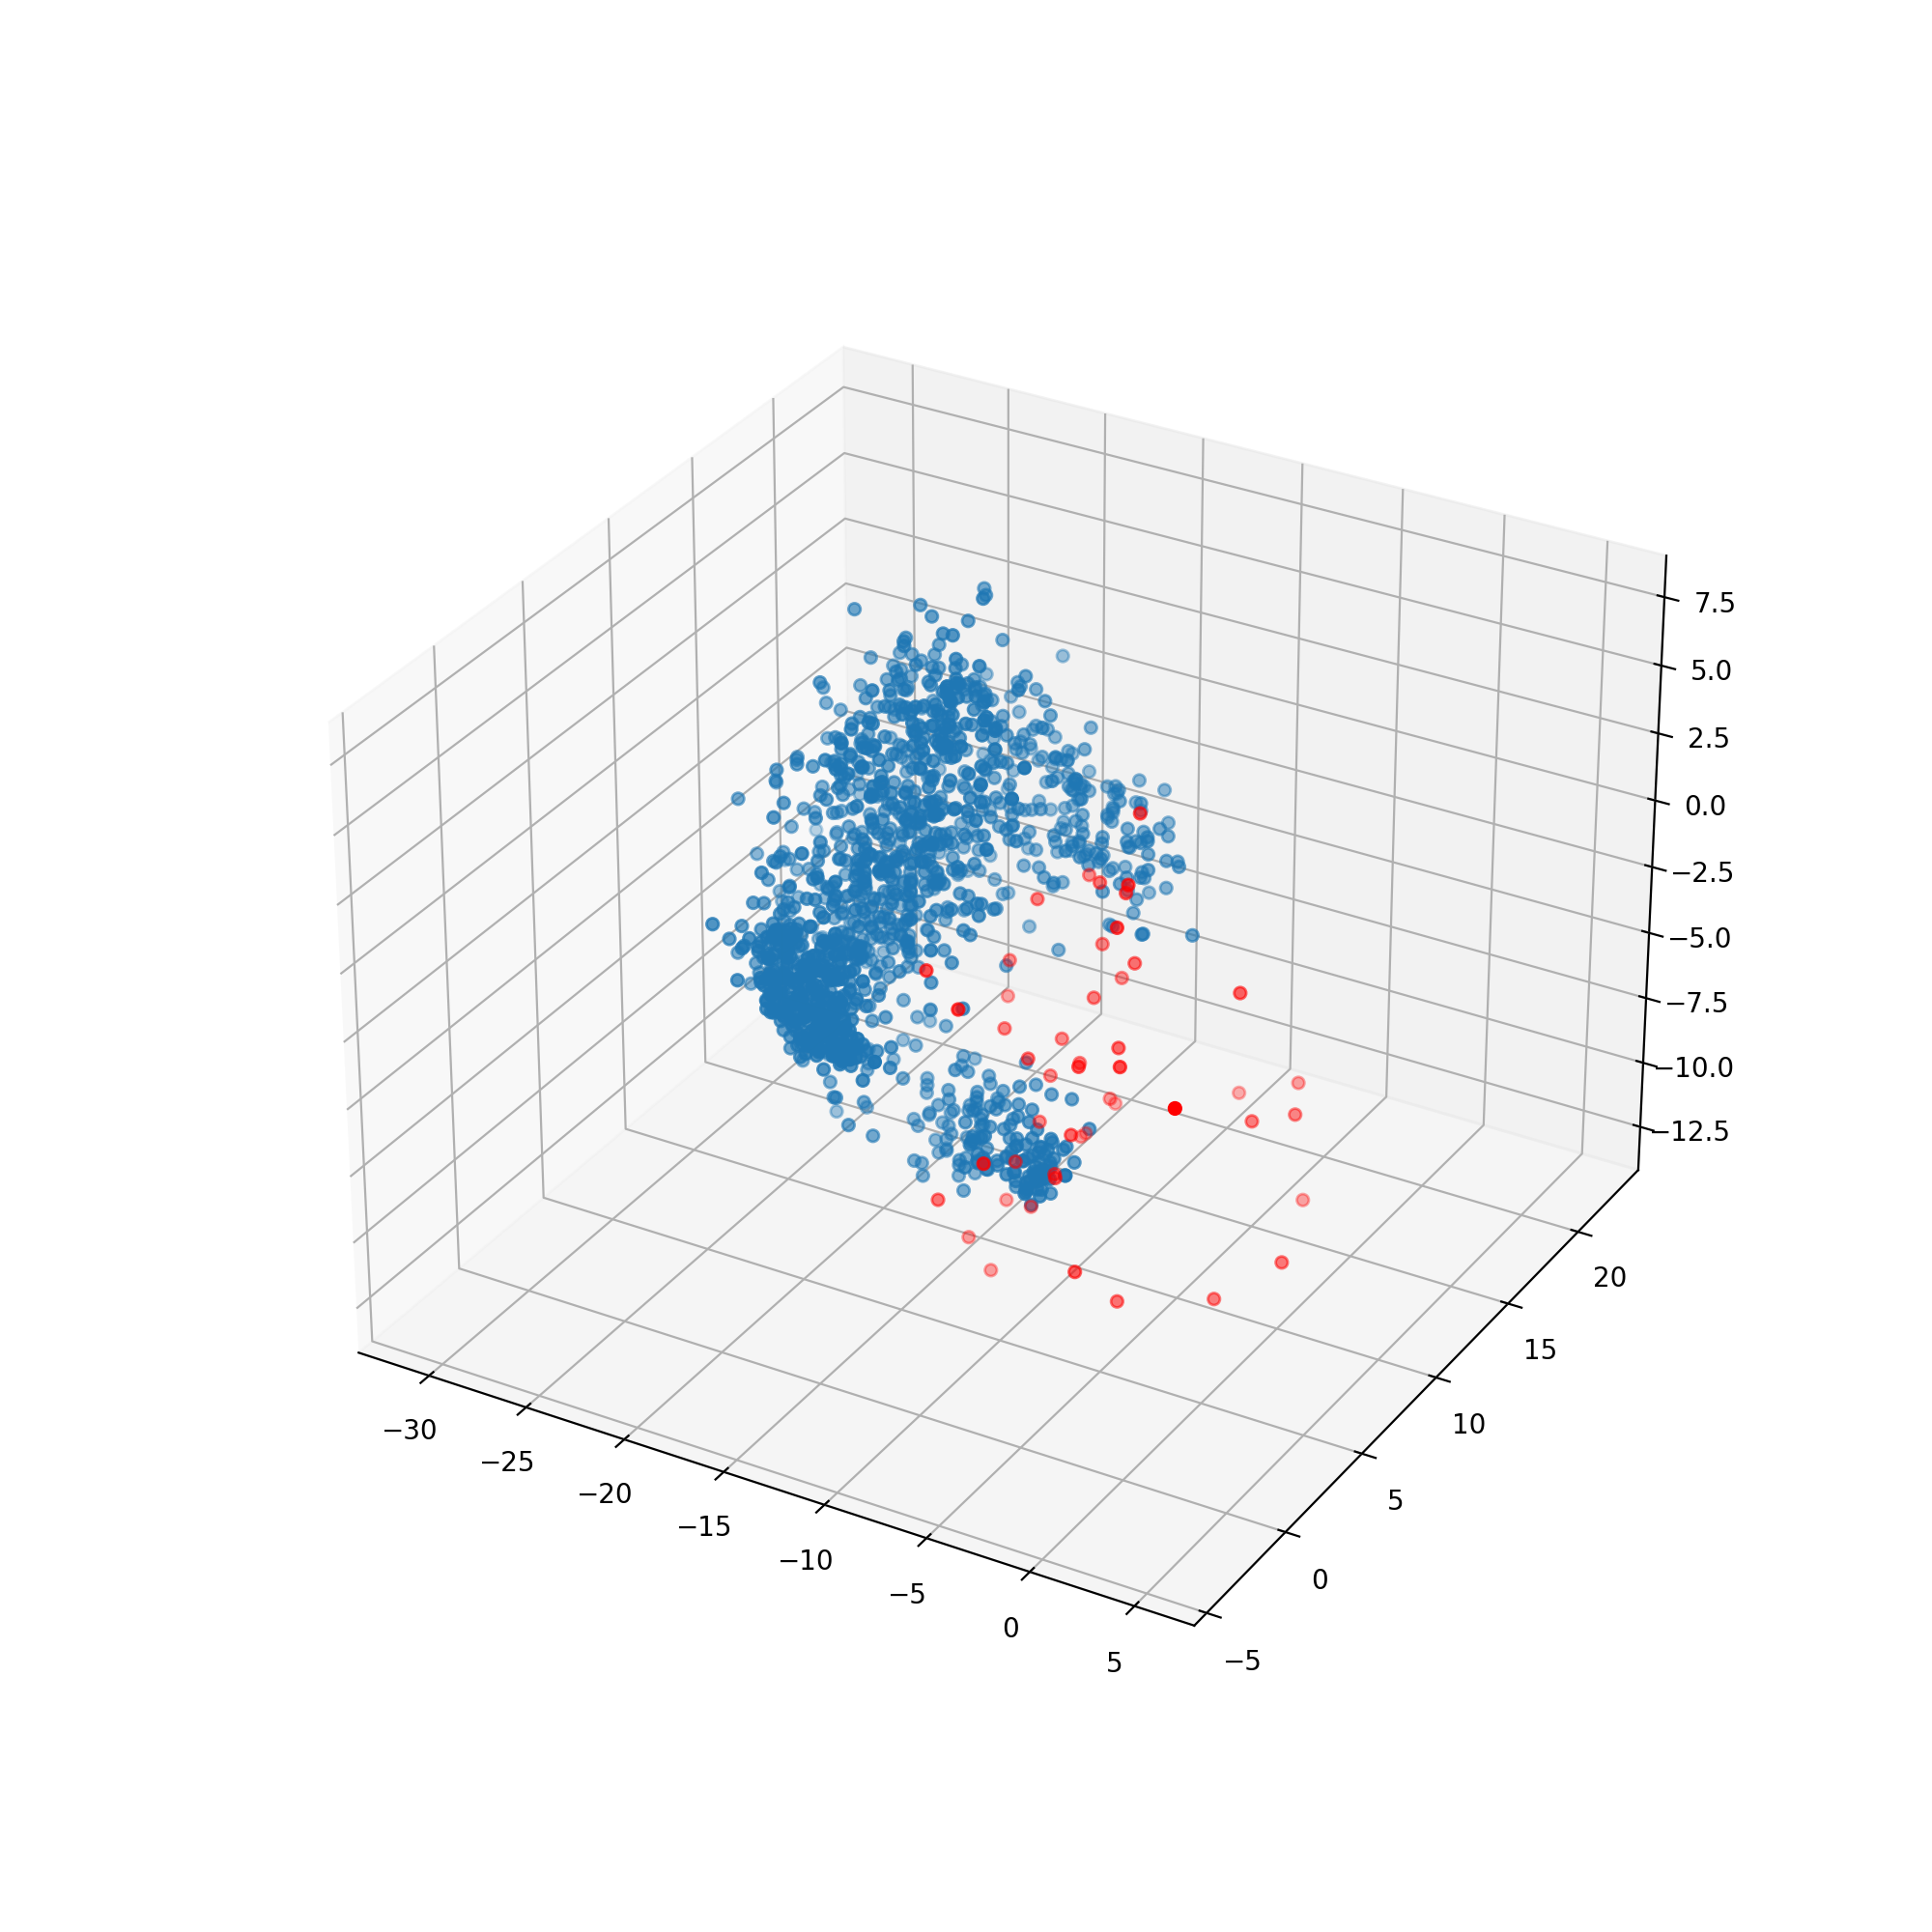

In [53]:
%matplotlib notebook

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

concept_cat = ax.scatter(mean_concept_in_feat_cat_na[0], mean_concept_in_feat_cat_na[1], mean_concept_in_feat_cat_na[2]) 

ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='red')

plt.show()

### Analysis: coordinates vs. memorability

#### Cartesian coordinates

In [15]:
### linreg: cartesian coordinates and z-score memorability
# normalized: R^2 = 0.098, adjusted = 0.096
# mobius: R^2 = 0.072, adjusted = 0.06
# mobius (S=48): R^2 = 0.117
import statsmodels.api as sm
import scipy.stats as stats

zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_constant = sm.add_constant(mean_concept_in_feat_cat[[0,1,2]], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     66.84
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           4.92e-41
Time:                        21:07:34   Log-Likelihood:                -2535.3
No. Observations:                1854   AIC:                             5079.
Df Residuals:                    1850   BIC:                             5101.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0785      0.006     13.998      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)



Predicting memorability using cartesian coordinates: x axis is most influential in memorability, whereas memorability decreased as coordinates going polsitively along y and z axes. 


#### Polar coordinates

In [16]:
### Polar coordinates of concepts in hyperbolic feature space
r, theta, rho = cart_to_polar(mean_concept_in_feat_cat[[0,1,2]].values).T
plt.hist2d(theta, rho,
           bins = 20)

(array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  1.,  1.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  6.,  5.,  2.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  2.,  2., 10., 13.,  7.,  2.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  3.,  1.,  4., 14., 14.,  7.,  5.,  6.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  3.,  4., 11., 22., 20., 15., 10.,  5.,
          1.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  4.,  5., 12., 14., 27., 27., 26., 16., 11.,
          5.,  2.,  0.,  0.,  0.,  1.,  1.],
        [ 0.,  0.,  1.,  2.,  3., 14.,  7., 14., 19., 32., 32., 21., 10.,
          3.,  3.,  4.,  5.,  3.,  1.,  0.],
        [ 0.,  2.,  5.,  8., 22.,  9.,  8.,  9.,

In [17]:
### linreg: polar coordinates vs. memorability
# normalized: R^2 = 0.074, adjusted = 0.072
# mobius: R^2 = 0.019, adjusted = 0.018
# mobius (S=48): R^2 = 0.091
zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_constant = sm.add_constant(np.array([r, theta, rho]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     48.97
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           1.89e-30
Time:                        21:07:34   Log-Likelihood:                -2559.9
No. Observations:                1854   AIC:                             5128.
Df Residuals:                    1850   BIC:                             5150.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0546      0.006     -9.931      0.0

Predicting memorability using polar coordinates: polar coordinates explained less variance in memorability than cartesian coordinates. Vertical angle of concepts in the hyperbolic space is the most influential variable in predicting memorability, where concepts closer to the core are more memorable, and concepts closer to the ceiling/floor of the space are more forgettable. 

#### Radius

<IPython.core.display.Javascript object>


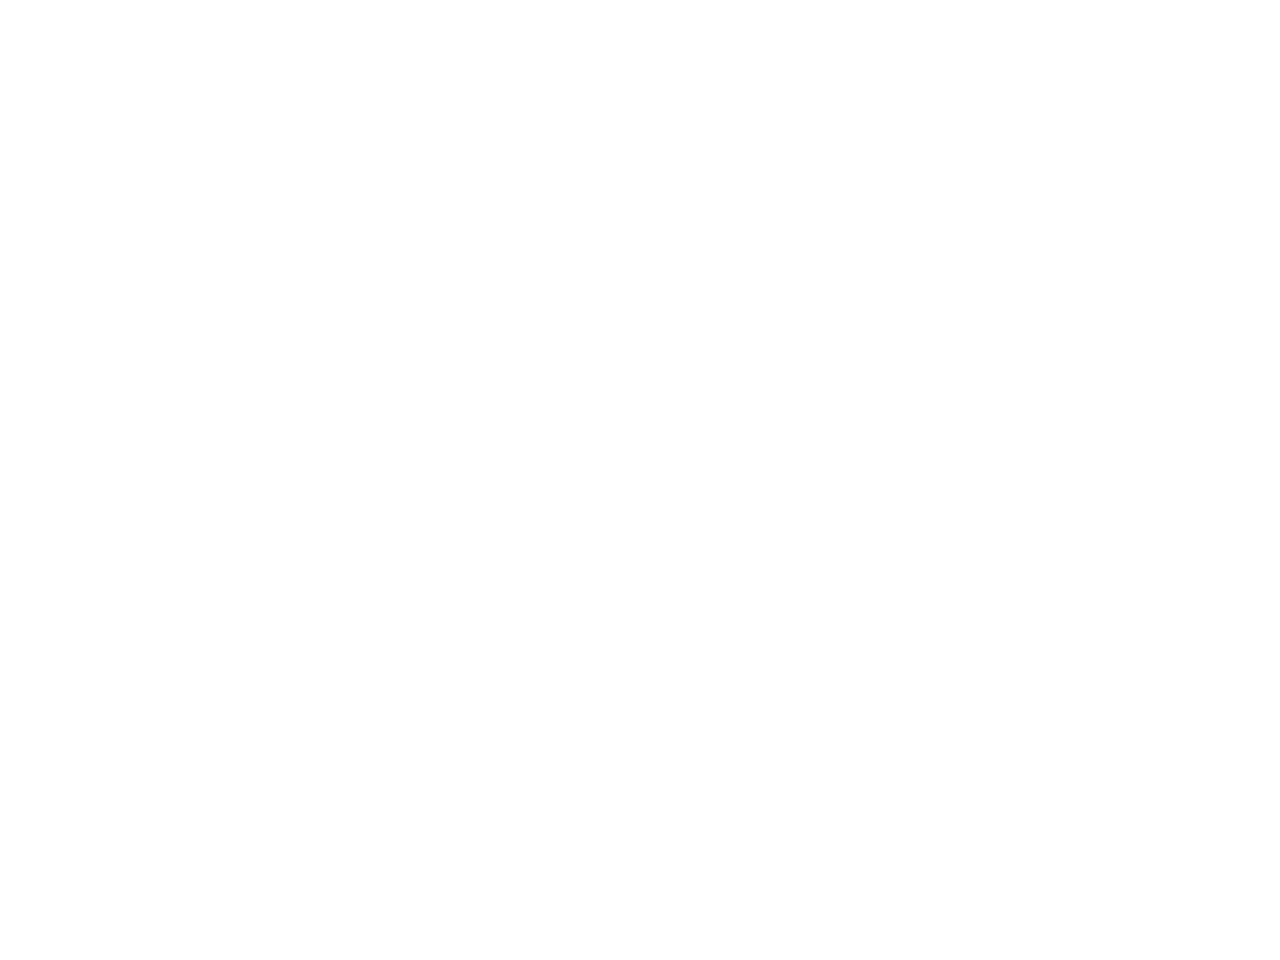

(array([ 43., 119., 218., 329., 406., 369., 229., 114.,  22.,   5.]),
 array([12.38486087, 14.85297531, 17.32108974, 19.78920417, 22.25731861,
        24.72543304, 27.19354747, 29.66166191, 32.12977634, 34.59789077,
        37.06600521]),
 <BarContainer object of 10 artists>)

In [18]:
### Radius
%matplotlib notebook
import matplotlib.pyplot as plt
concept_radius_in_feat = np.sqrt((mean_concept_in_feat_cat[[0,1,2]]**2).sum(1))

plt.clf()
plt.hist(concept_radius_in_feat)

In [19]:
### Radius vs. memorability
# normalized: R^2 = 0.037, adjusted = 0.037
# mobius: R^2 = 0.014, adjusted = 0.013
zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_radius_const = sm.add_constant(concept_radius_in_feat, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_radius_const)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     71.58
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           5.33e-17
Time:                        21:07:34   Log-Likelihood:                -2595.6
No. Observations:                1854   AIC:                             5195.
Df Residuals:                    1852   BIC:                             5206.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0451      0.005     -8.460      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Predicting memorability using radius: radius of concepts in the hyperbolic space explained even smaller variance in memorability. Concepts that have shorter radius are closer to the core of the space and are more memorable. 

#### K-Means

In [116]:
### K-Means clustering on concepts
kmeans = KMeans(n_clusters=4, random_state=42).fit(mean_concept_in_feat_cat[[0,1,2]])
labels = kmeans.labels_
concept_coord_cluster = mean_concept_in_feat_cat
concept_coord_cluster['label'] = labels
kmeans.cluster_centers_


array([[-23.5264825 ,  13.32875646,  -3.37891637],
       [-17.95248956,  13.51341043,   0.78618591],
       [-18.7342096 ,   5.11833356,  -2.1847011 ],
       [-13.31458044,   9.12927484,  -8.96434954]])

<IPython.core.display.Javascript object>


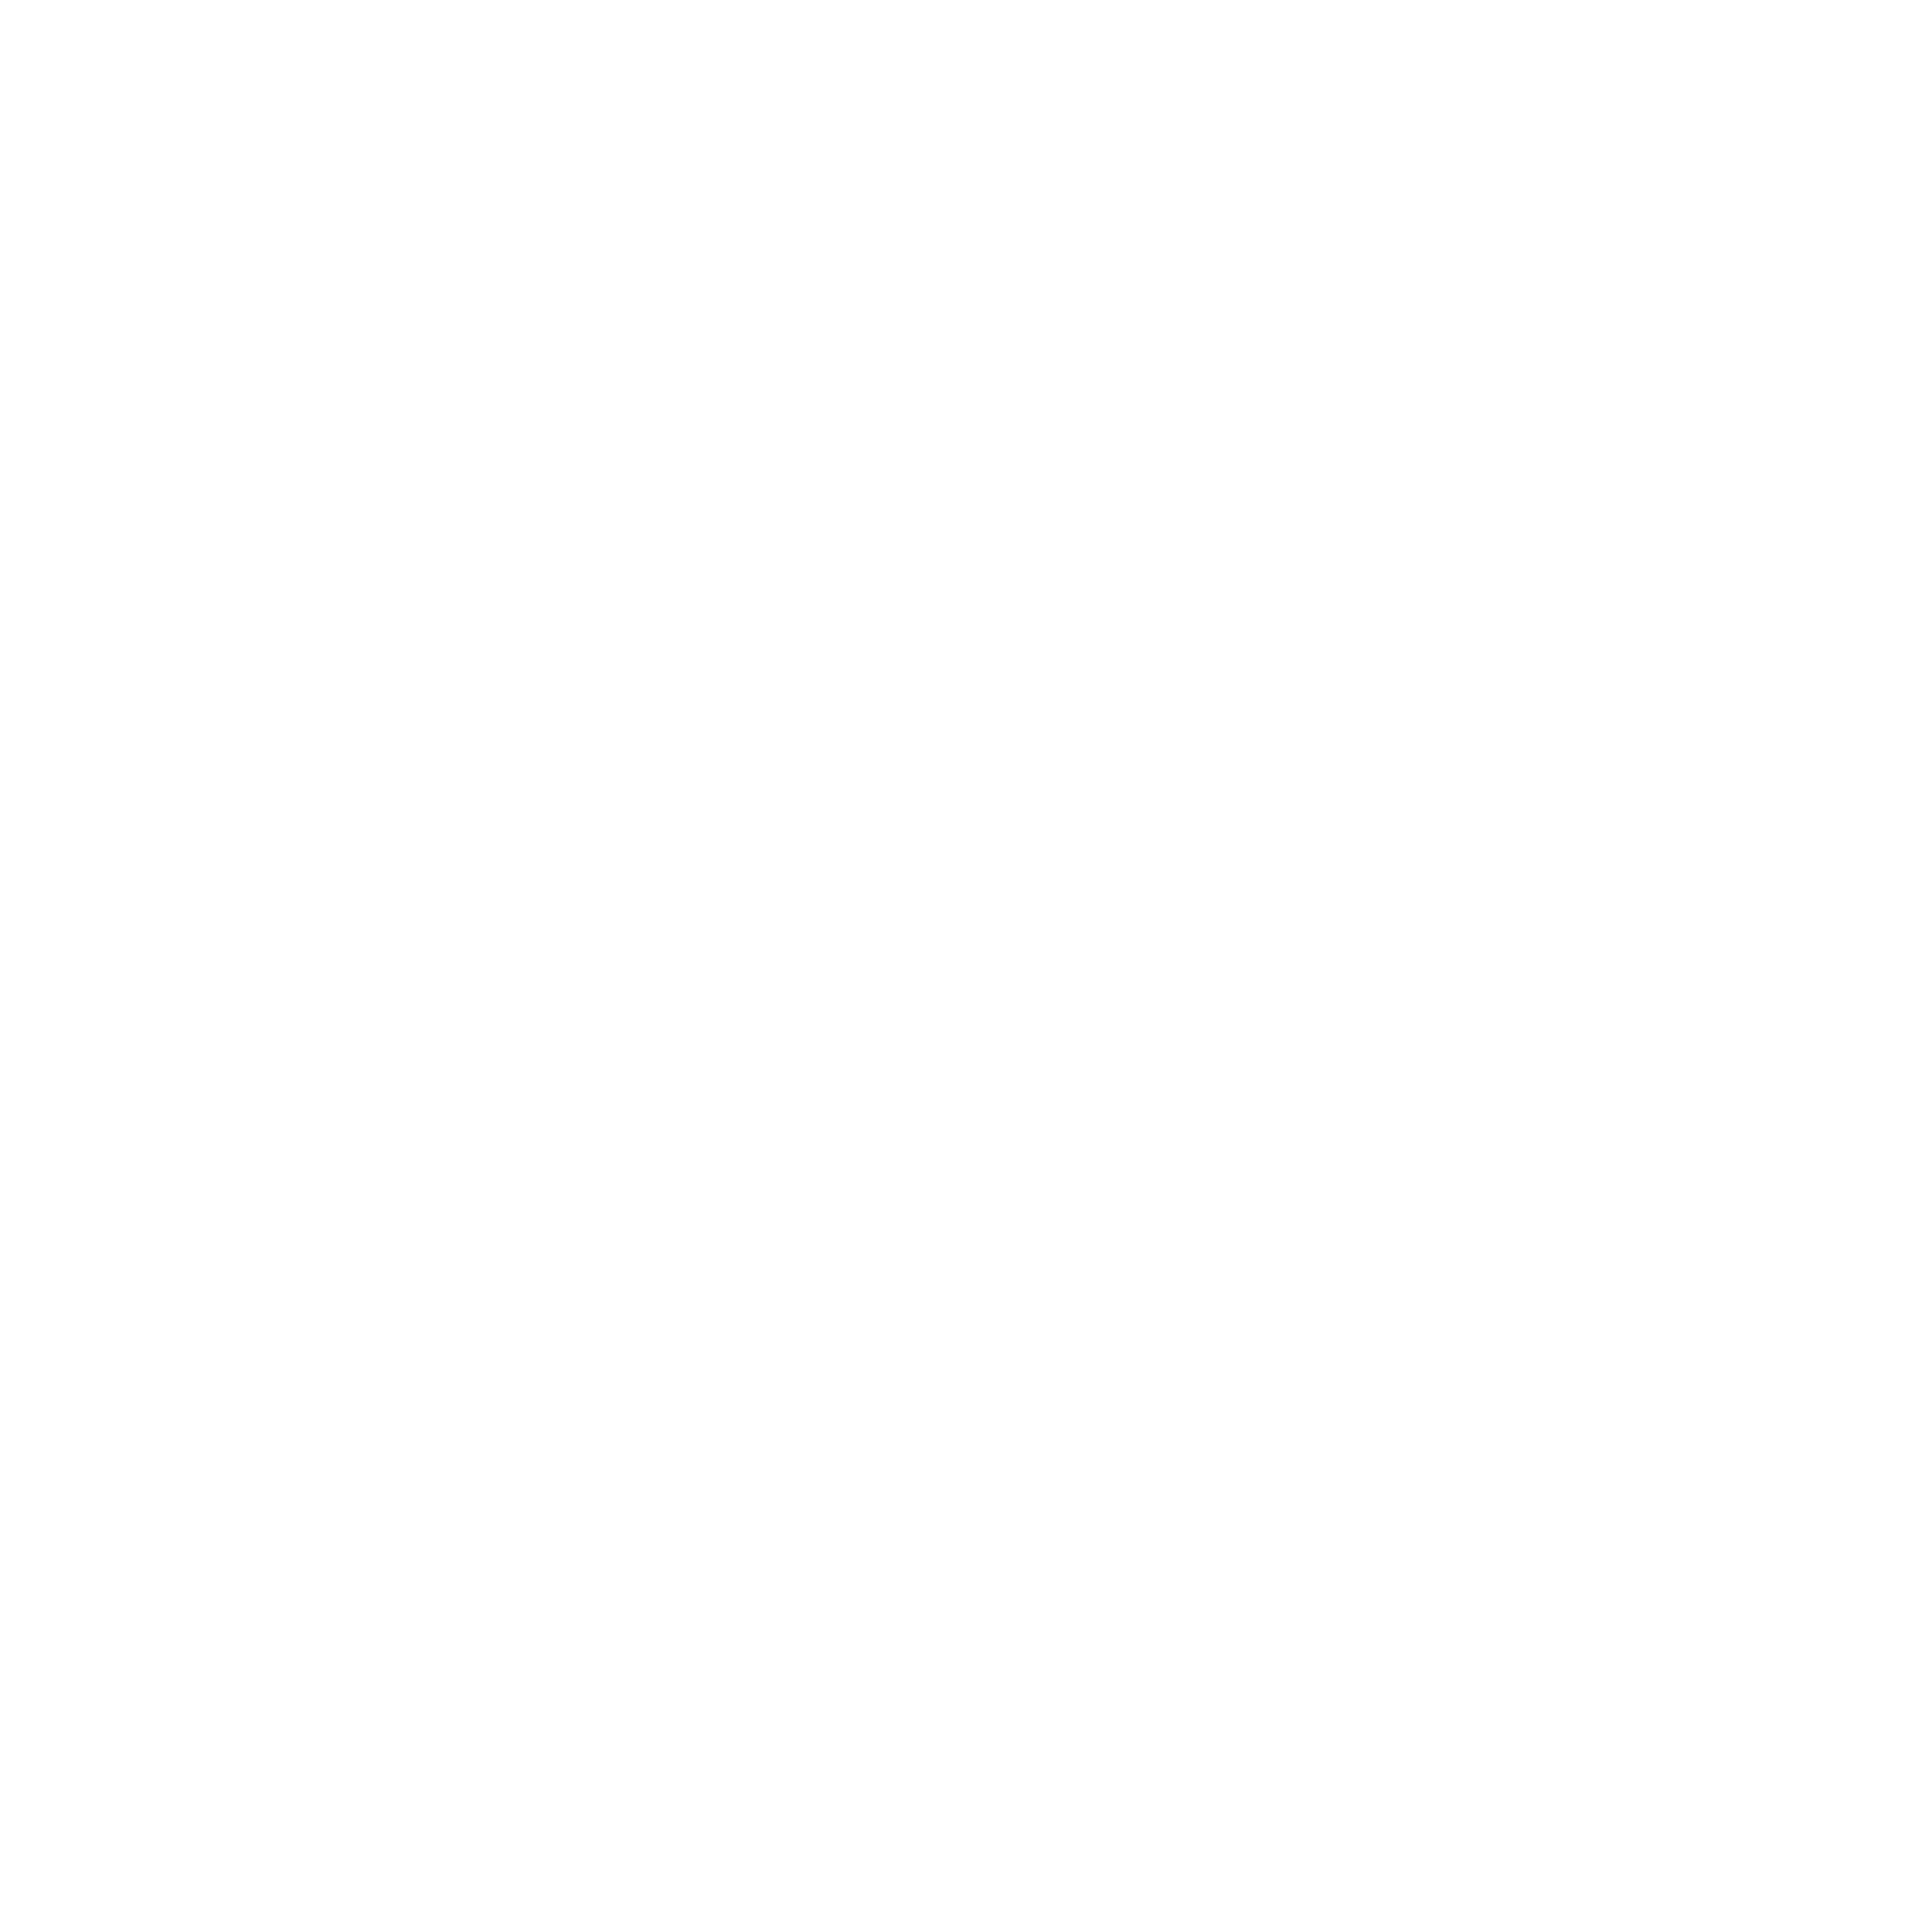

In [21]:
### clusters by memorability and plot concept coordinates in feature space
%matplotlib notebook


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(mean_concept_in_feat_cat[0], mean_concept_in_feat_cat[1], mean_concept_in_feat_cat[2], c=labels, alpha=0.5)


In [22]:
### cluster 0: cartesian coordinates vs. memorability
cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[[0,1,2]], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     4.238
Date:                Sun, 21 Aug 2022   Prob (F-statistic):            0.00558
Time:                        21:07:34   Log-Likelihood:                -947.19
No. Observations:                 672   AIC:                             1902.
Df Residuals:                     668   BIC:                             1920.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0057      0.017      0.330      0.7

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [23]:
### cluster 0: polar coordinates vs. memorability
polar_cluster_0 = cart_to_polar(cluster_0[[0,1,2]].values) - cart_to_polar(concept_coord_cluster[[0,1,2]].values).mean(0)
cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_0, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     4.322
Date:                Sun, 21 Aug 2022   Prob (F-statistic):            0.00497
Time:                        21:07:34   Log-Likelihood:                -947.07
No. Observations:                 672   AIC:                             1902.
Df Residuals:                     668   BIC:                             1920.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0244      0.016      1.559      0.1

In [24]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1[[0,1,2]], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     92.59
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           3.39e-49
Time:                        21:07:34   Log-Likelihood:                -736.59
No. Observations:                 600   AIC:                             1481.
Df Residuals:                     596   BIC:                             1499.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1288      0.013      9.992      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [25]:
### cluster 1: polar coordinates vs. memorability
polar_cluster_1 = cart_to_polar(cluster_1[[0,1,2]].values) - cart_to_polar(concept_coord_cluster[[0,1,2]].values).mean(0)
cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_1, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     89.52
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           7.87e-48
Time:                        21:07:34   Log-Likelihood:                -739.77
No. Observations:                 600   AIC:                             1488.
Df Residuals:                     596   BIC:                             1505.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0189      0.013     -1.434      0.1

In [26]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2[[0,1,2]], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     16.65
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           3.22e-10
Time:                        21:07:34   Log-Likelihood:                -556.56
No. Observations:                 409   AIC:                             1121.
Df Residuals:                     405   BIC:                             1137.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0665      0.023     -2.923      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [27]:
### cluster 2: polar coordinates vs. memorability
polar_cluster_2 = cart_to_polar(cluster_2[[0,1,2]].values) - cart_to_polar(concept_coord_cluster[[0,1,2]].values).mean(0)
cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_2, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     15.01
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           2.77e-09
Time:                        21:07:34   Log-Likelihood:                -558.78
No. Observations:                 409   AIC:                             1126.
Df Residuals:                     405   BIC:                             1142.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0245      0.021      1.186      0.2

In [28]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3[[0,1,2]], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     12.15
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           3.08e-07
Time:                        21:07:34   Log-Likelihood:                -228.59
No. Observations:                 173   AIC:                             465.2
Df Residuals:                     169   BIC:                             477.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1483      0.032      4.663      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [29]:
### cluster 3: polar coordinates vs. memorability
polar_cluster_3 = cart_to_polar(cluster_3[[0,1,2]].values) - cart_to_polar(concept_coord_cluster[[0,1,2]].values).mean(0)
cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_3, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     11.82
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           4.54e-07
Time:                        21:07:34   Log-Likelihood:                -229.00
No. Observations:                 173   AIC:                             466.0
Df Residuals:                     169   BIC:                             478.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0284      0.028     -1.014      0.3

<IPython.core.display.Javascript object>


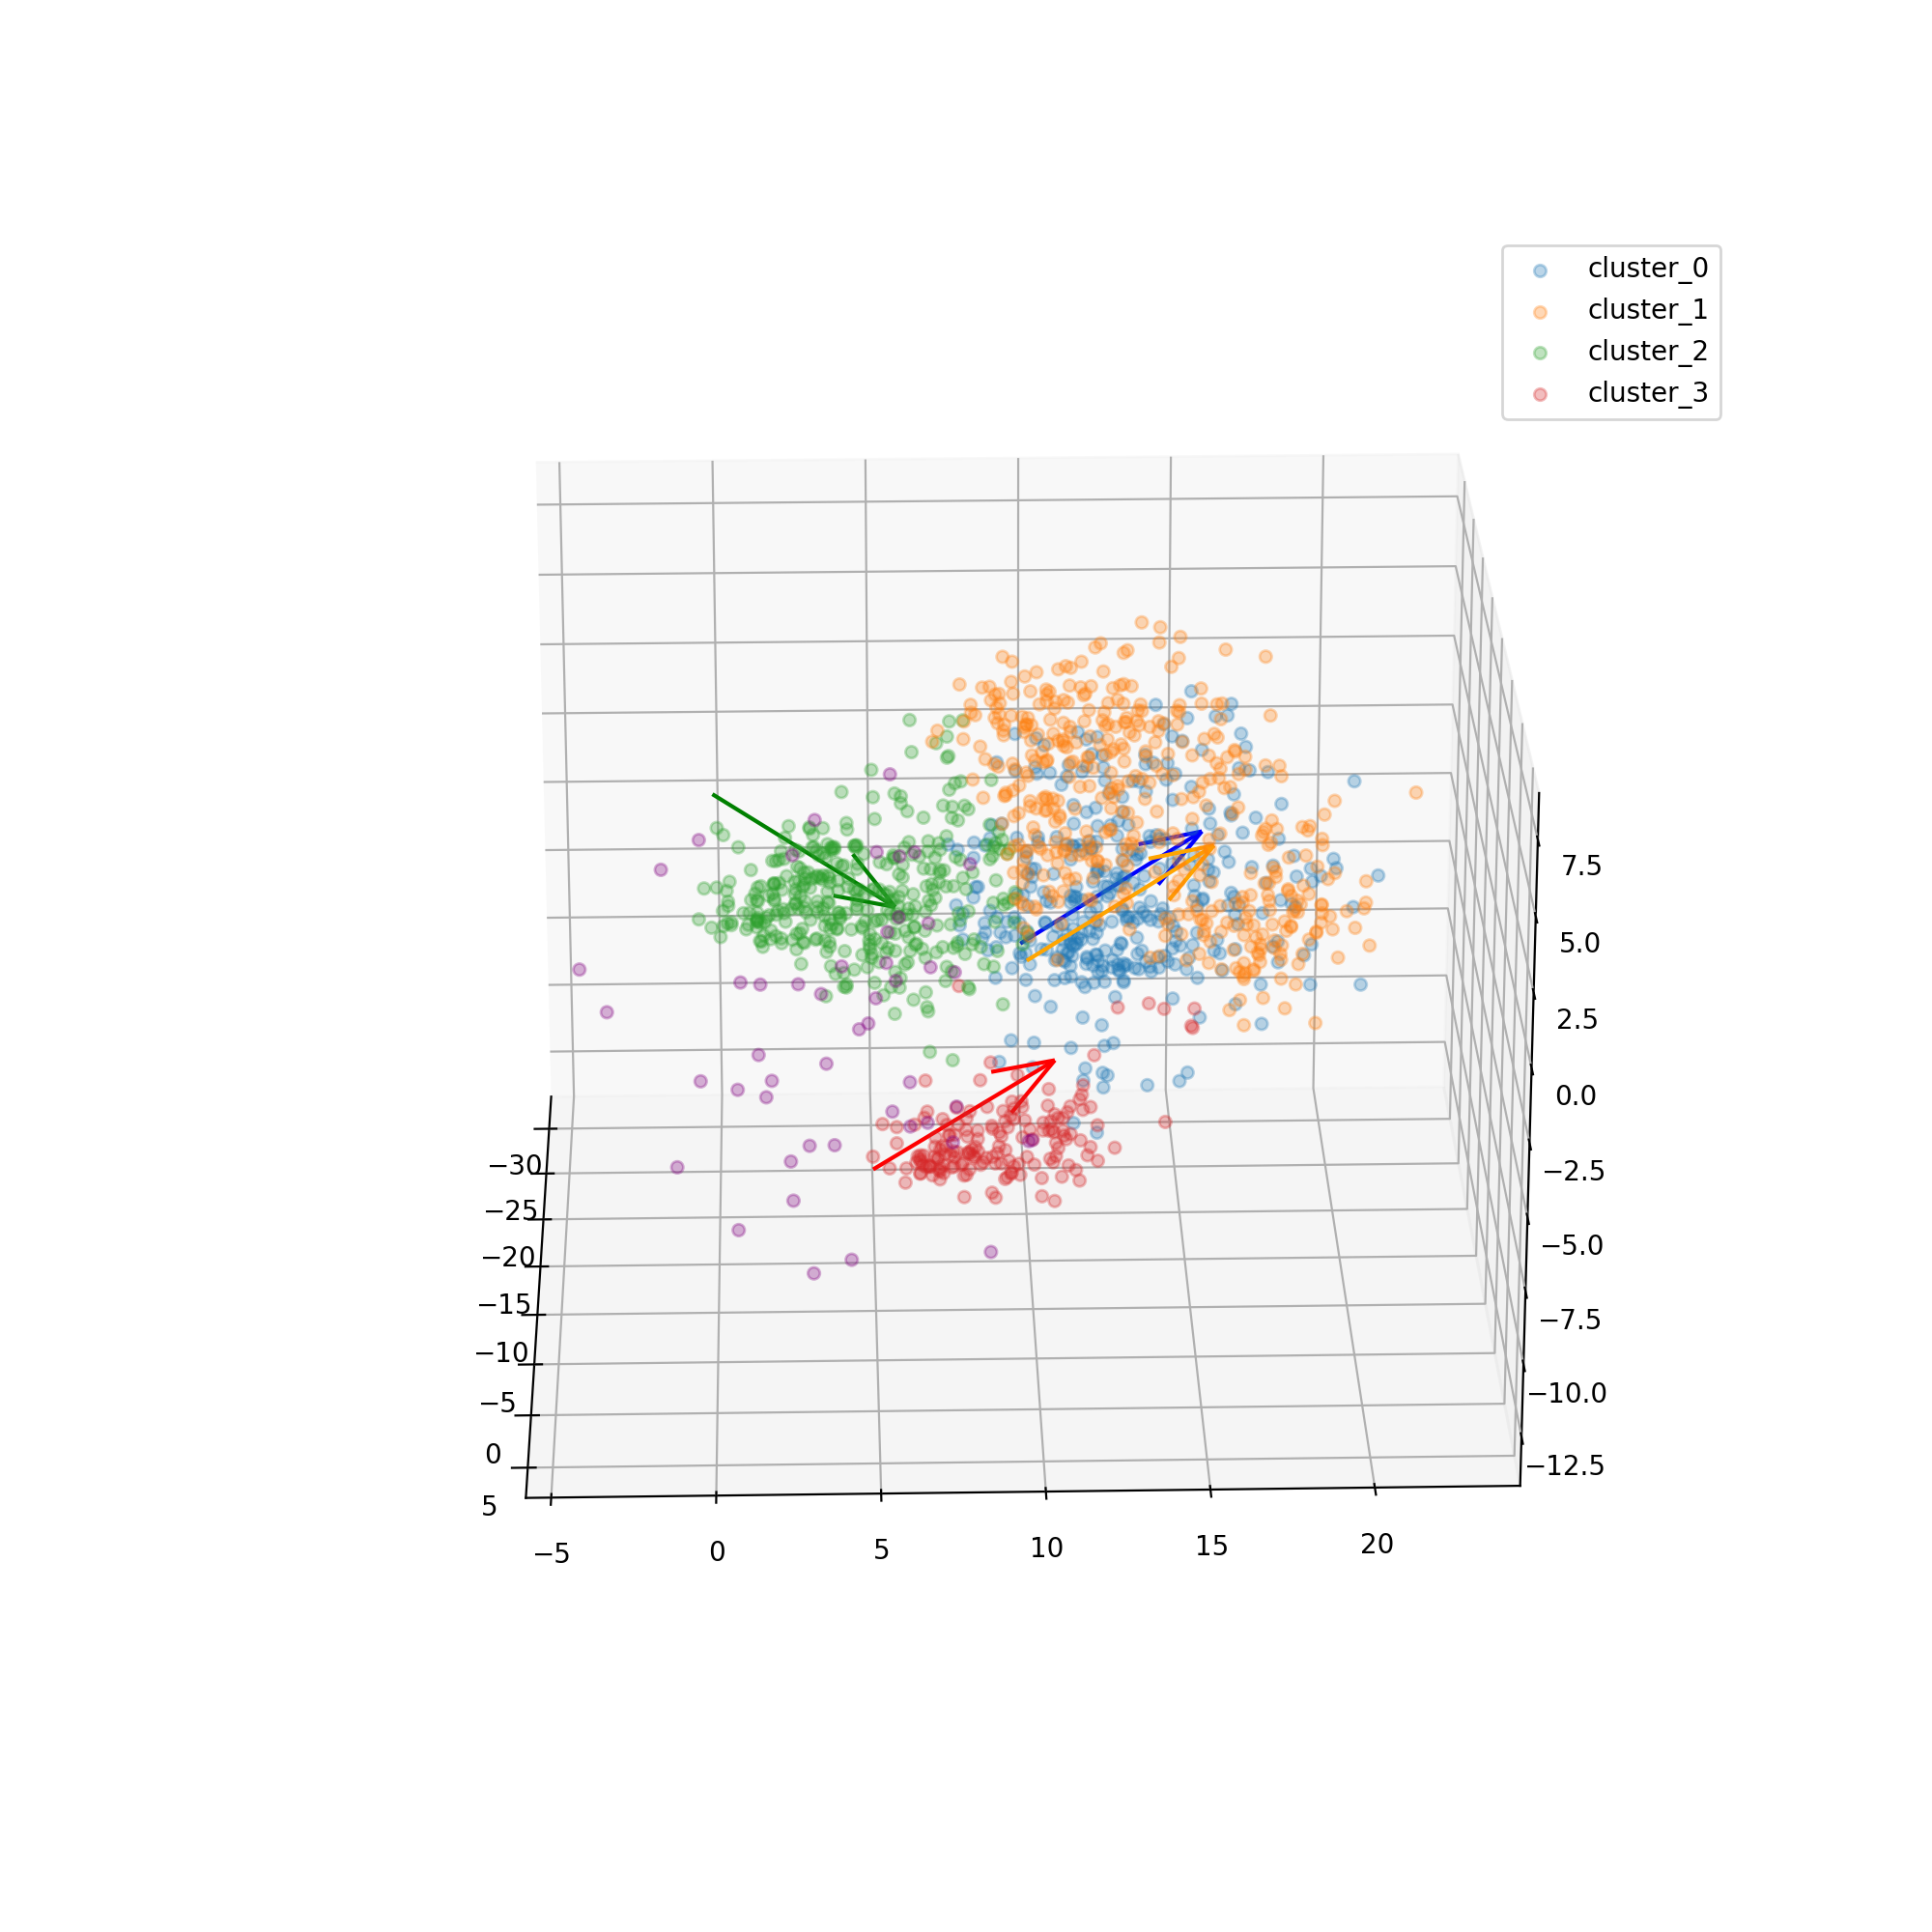

In [87]:
### Memorability changes by coordinates in each cluster
# normalized: highest R^2 (cluster 1) = 0.318
# mobius: highest R^2 (cluster 3) = 0.123

%matplotlib notebook

# plt.clf()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(cluster_0[0], cluster_0[1], cluster_0[2], label='cluster_0', alpha=0.3)
# ax.plot(np.linspace(-30,-20,100), np.linspace(10,20,100), -2.5+-.5+np.linspace(-30,-20,100)*.0057+ np.linspace(10,20,100)*.0509+ np.linspace(-7.5, 2.5, 100)*.0108, label='cluster_0', alpha=1)
# ax.plot(np.linspace(-15,-5,100), np.linspace(5,15,100), -.3135+np.linspace(-15,-5,100)*.1324+ np.linspace(5,15,100)*.1098+ np.linspace(-5, 5, 100)*-.0734, label='cluster_0', alpha=1)
ax.quiver(-30, 10, -7.5, 10, 10, 10, length = 10, normalize = True, color='blue')


# c0_grid = np.meshgrid(np.linspace(-20,-30,100), np.linspace(10,20,100))
# ax.plot_surface(c0_grid[0], c0_grid[1], -.5+X*.0057+ Y*.0509, label='cluster_0', alpha=1)

ax.scatter(cluster_1[0], cluster_1[1], cluster_1[2], label='cluster_1', alpha=0.3)
# ax.plot(np.linspace(-20,-10,100), np.linspace(10,20,100), .59+np.linspace(-20,-10,100)*.1288+ np.linspace(10,20,100)*.1266+ np.linspace(-5, 5, 100)*.0101, label='cluster_1', alpha=1)
# ax.plot(np.linspace(-20,-10,100), np.linspace(-2.5,7.5,100), -1.5349+np.linspace(-20,-10,100)*-.1115+ np.linspace(-2.5,7.5,100)*-.0823+ np.linspace(-5, 5, 100)*.0273, label='cluster_1', alpha=1)
ax.quiver(-20, 10, -5, 10, 10, 10, length = 10, normalize = True, color='orange')


# c1_grid = np.meshgrid(np.linspace(-10,-20,100), np.linspace(10,20,100))
# ax.plot_surface(c1_grid[0], c1_grid[1], .59+X*.1288+ Y*.1266, label='cluster_1', alpha=1)

ax.scatter(cluster_2[0], cluster_2[1], cluster_2[2], label='cluster_2', alpha=0.3)
# ax.plot(np.linspace(-25,-15,100), np.linspace(0,10,100), -.49+np.linspace(-25,-15,100)*-.0665+ np.linspace(0,10,100)*-.1488+ np.linspace(-7.5, 2.5, 100)*-.0007, label='cluster_2', alpha=1)
# ax.plot(np.linspace(-15,-5,100), np.linspace(10,0,100), 1.6519+np.linspace(-15,-5,100)*.1747+ np.linspace(10,0,100)*-.0601+ np.linspace(0, 10, 100)*.0127, label='cluster_2', alpha=1)
ax.quiver(-15, 0, 2.5, -10, 10, -10, length = 10, normalize = True, color='green')


# c2_grid = np.meshgrid(np.linspace(-25,-15,100), np.linspace(0,10,100))
# ax.plot_surface(c2_grid[0], c2_grid[1], -.49+X*-.0665+ Y*-.1488, label='cluster_2', alpha=1)

ax.scatter(cluster_3[0], cluster_3[1], cluster_3[2], label='cluster_3', alpha=0.3)
# ax.plot(np.linspace(-20,-10,100), np.linspace(5,15,100), -10+.47+np.linspace(-20,-10,100)*.1483+ np.linspace(5,15,100)*.1887+ np.linspace(-12.5, -7.5, 100)*.0244, label='cluster_3', alpha=1)
# ax.plot(np.linspace(-17.5,-7.5,100), np.linspace(10,0,100), 1.0544+np.linspace(-17.5,-7.5,100)*.1962+ np.linspace(10,0,100)*-.1758+ np.linspace(0, -10, 100)*.0596, label='cluster_3', alpha=1)
ax.quiver(-20, 5, -12.5, 10, 10, 10, length = 10, normalize = True, color='red')


# c3_grid = np.meshgrid(np.linspace(-10,-20,100), np.linspace(5,15,100))
# ax.plot_surface(c3_grid[0], c3_grid[1], .47+X*.1483+ Y*.1887, label='cluster_3', alpha=1)

ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='purple', alpha=.3)

plt.legend()


In [31]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.1504157690242467

### Analysis: coordinates, typicality, memorability

In [32]:
def calculate_typicality(group):
    """
    Calculate typicality of each concept using average similarity within category 
    """
    feat_matrix = []
    for concept in group['index']:
        feat_matrix.append(original_embeddings[concept])
    coef_matrix = np.corrcoef(feat_matrix)
    typicality = (np.sum(coef_matrix, axis=1)-1)/len(coef_matrix)
    group['typicality'] = typicality
    return group

In [33]:
grouped = mean_concept_in_feat_cat_na.groupby('bigcat')
grouped = grouped.apply(calculate_typicality)
grouped

,index,0,1,2,cr,bigcat,cat_name,typicality
0,0,-8.362256,5.447828,-8.557188,0.779739,1,animal,0.810913
1,1,-26.123590,12.240625,0.518939,0.798485,13,home decor,0.247628
2,2,-24.385152,14.180849,0.693800,0.752845,18,musical instrument,0.624589
4,4,-20.330699,11.947785,-4.992442,0.794466,9,electronic device,0.522380
5,5,-24.493047,16.661652,-4.482670,0.806000,12,furniture,0.509185
...,...,...,...,...,...,...,...,...
1847,1847,-18.208906,9.885611,3.776987,0.803129,24,toy,0.246697
1848,1848,-19.281246,4.272460,-1.785376,0.765881,10,food,0.786900
1850,1850,-19.551059,2.813812,-2.150868,0.843158,10,food,0.770485
1851,1851,-14.748351,9.486465,-8.609210,0.800163,1,animal,0.764335


In [34]:
### Cartesian coordinates vs. typicality
# normalized: R^2 = 0.479, adjusted = 0.478
# mobius: R^2 = 0.136, adjusted = 0.134

zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(grouped[[0,1,2]], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     404.4
Date:                Sun, 21 Aug 2022   Prob (F-statistic):          2.80e-186
Time:                        21:07:34   Log-Likelihood:                -1447.1
No. Observations:                1324   AIC:                             2902.
Df Residuals:                    1320   BIC:                             2923.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0993      0.005     19.365      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [35]:
### Polar coordinates vs. typicality
r, theta, rho = cart_to_polar(grouped[[0,1,2]].values).T

zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(np.array([r, theta, rho]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     372.3
Date:                Sun, 21 Aug 2022   Prob (F-statistic):          3.51e-175
Time:                        21:07:34   Log-Likelihood:                -1472.8
No. Observations:                1324   AIC:                             2954.
Df Residuals:                    1320   BIC:                             2974.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1259      0.005    -23.915      0.0

In [36]:
### Radius vs. typicality
concept_radius_typ = np.sqrt((grouped[[0,1,2]]**2).sum(1))
zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(concept_radius_typ, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     838.2
Date:                Sun, 21 Aug 2022   Prob (F-statistic):          3.86e-143
Time:                        21:07:34   Log-Likelihood:                -1553.6
No. Observations:                1324   AIC:                             3111.
Df Residuals:                    1322   BIC:                             3122.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1494      0.005    -28.951      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [37]:
### typicality vs. memorability
# R^2 = 0.032, adjusted = 0.031

zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(grouped['typicality'], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     43.72
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           5.50e-11
Time:                        21:07:34   Log-Likelihood:                -1857.1
No. Observations:                1324   AIC:                             3718.
Df Residuals:                    1322   BIC:                             3729.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
typicality     0.9536      0.144      6.612      0.0

In [38]:
### Cartesian coordinates and typicality vs. memorability
zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(np.array(grouped[[0,1,2,'typicality']]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     39.48
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           2.92e-31
Time:                        21:07:34   Log-Likelihood:                -1803.8
No. Observations:                1324   AIC:                             3618.
Df Residuals:                    1319   BIC:                             3644.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0737      0.008      9.691      0.0

In [39]:
### Polar coordinates and typicality vs. memorability
zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(np.array([grouped['typicality'], r, theta, rho]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     30.40
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           3.13e-24
Time:                        21:07:34   Log-Likelihood:                -1820.3
No. Observations:                1324   AIC:                             3651.
Df Residuals:                    1319   BIC:                             3677.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6734      0.191      3.529      0.0

In [40]:
### Radius and typicality vs. memorability
zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(np.array([grouped['typicality'], concept_radius_typ]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     31.72
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           3.50e-14
Time:                        21:07:34   Log-Likelihood:                -1847.6
No. Observations:                1324   AIC:                             3701.
Df Residuals:                    1321   BIC:                             3717.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4547      0.183      2.483      0.0

##### Cluster level typicality

In [41]:
# ### K-Means clustering on concepts
# kmeans = KMeans(n_clusters=4, random_state=42).fit(grouped[[0,1,2]])
# labels = kmeans.labels_
# concept_coord_cluster = grouped
# concept_coord_cluster['label'] = labels
# kmeans.cluster_centers_


In [129]:
typ_coord_cluster = concept_coord_cluster.merge(grouped[['index','typicality']], how='inner', on='index')
typ_coord_cluster

,index,0,1,2,cr,bigcat,cat_name,label,typicality
0,0,-8.362256,5.447828,-8.557188,0.779739,1,animal,3,0.810913
1,1,-26.123590,12.240625,0.518939,0.798485,13,home decor,0,0.247628
2,2,-24.385152,14.180849,0.693800,0.752845,18,musical instrument,0,0.624589
3,4,-20.330699,11.947785,-4.992442,0.794466,9,electronic device,0,0.522380
4,5,-24.493047,16.661652,-4.482670,0.806000,12,furniture,0,0.509185
...,...,...,...,...,...,...,...,...,...
1319,1847,-18.208906,9.885611,3.776987,0.803129,24,toy,1,0.246697
1320,1848,-19.281246,4.272460,-1.785376,0.765881,10,food,2,0.786900
1321,1850,-19.551059,2.813812,-2.150868,0.843158,10,food,2,0.770485
1322,1851,-14.748351,9.486465,-8.609210,0.800163,1,animal,3,0.764335


In [159]:
### cluster 0: cartesian coordinates vs. memorability
cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[[0,1,2, 'typicality']], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     5.295
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           0.000376
Time:                        22:35:58   Log-Likelihood:                -496.13
No. Observations:                 357   AIC:                             1002.
Df Residuals:                     352   BIC:                             1022.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0543      0.025      2.152      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [160]:
### cluster 0: polar coordinates vs. memorability
polar_cluster_0 = cluster_0.copy()
polar_cluster_0[[0,1,2]] = cart_to_polar(cluster_0[[0,1,2]].values) - cart_to_polar(typ_coord_cluster[[0,1,2]].values).mean(0)
zscore_mem = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_0[[0,1,2,'typicality']], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     4.795
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           0.000888
Time:                        22:35:59   Log-Likelihood:                -497.09
No. Observations:                 357   AIC:                             1004.
Df Residuals:                     352   BIC:                             1024.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0164      0.024     -0.697      0.4

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [161]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1[[0,1,2,'typicality']], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     52.76
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           3.03e-36
Time:                        22:36:07   Log-Likelihood:                -538.70
No. Observations:                 441   AIC:                             1087.
Df Residuals:                     436   BIC:                             1108.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1313      0.016      8.446      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [162]:
### cluster 1: polar coordinates vs. memorability
polar_cluster_1 = cluster_1.copy()
polar_cluster_1[[0,1,2]] = cart_to_polar(cluster_1[[0,1,2]].values) - cart_to_polar(typ_coord_cluster[[0,1,2]].values).mean(0)
zscore_mem = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_1[[0,1,2,'typicality']], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     51.40
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           1.89e-35
Time:                        22:36:13   Log-Likelihood:                -540.57
No. Observations:                 441   AIC:                             1091.
Df Residuals:                     436   BIC:                             1112.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0149      0.015     -0.960      0.3

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [163]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2[[0,1,2,'typicality']], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     15.35
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           1.35e-11
Time:                        22:36:22   Log-Likelihood:                -484.93
No. Observations:                 362   AIC:                             979.9
Df Residuals:                     357   BIC:                             999.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1014      0.026     -3.963      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [164]:
### cluster 2: polar coordinates vs. memorability
polar_cluster_2 = cluster_2.copy()
polar_cluster_2[[0,1,2]] = cart_to_polar(cluster_2[[0,1,2]].values) - cart_to_polar(typ_coord_cluster[[0,1,2]].values).mean(0)
zscore_mem = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_2[[0,1,2,'typicality']], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     14.08
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           1.11e-10
Time:                        22:36:52   Log-Likelihood:                -487.14
No. Observations:                 362   AIC:                             984.3
Df Residuals:                     357   BIC:                             1004.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0560      0.023      2.423      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [165]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3[[0,1,2,'typicality']], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     7.463
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           1.55e-05
Time:                        22:36:58   Log-Likelihood:                -218.60
No. Observations:                 164   AIC:                             447.2
Df Residuals:                     159   BIC:                             462.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1842      0.044      4.212      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [166]:
### cluster 3: polar coordinates vs. memorability
polar_cluster_3 = cluster_3.copy()
polar_cluster_3[[0,1,2]] = cart_to_polar(cluster_3[[0,1,2]].values) - cart_to_polar(typ_coord_cluster[[0,1,2]].values).mean(0)
zscore_mem = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_3[[0,1,2,'typicality']], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     7.121
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           2.67e-05
Time:                        22:37:32   Log-Likelihood:                -219.19
No. Observations:                 164   AIC:                             448.4
Df Residuals:                     159   BIC:                             463.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0293      0.031     -0.944      0.3

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<IPython.core.display.Javascript object>


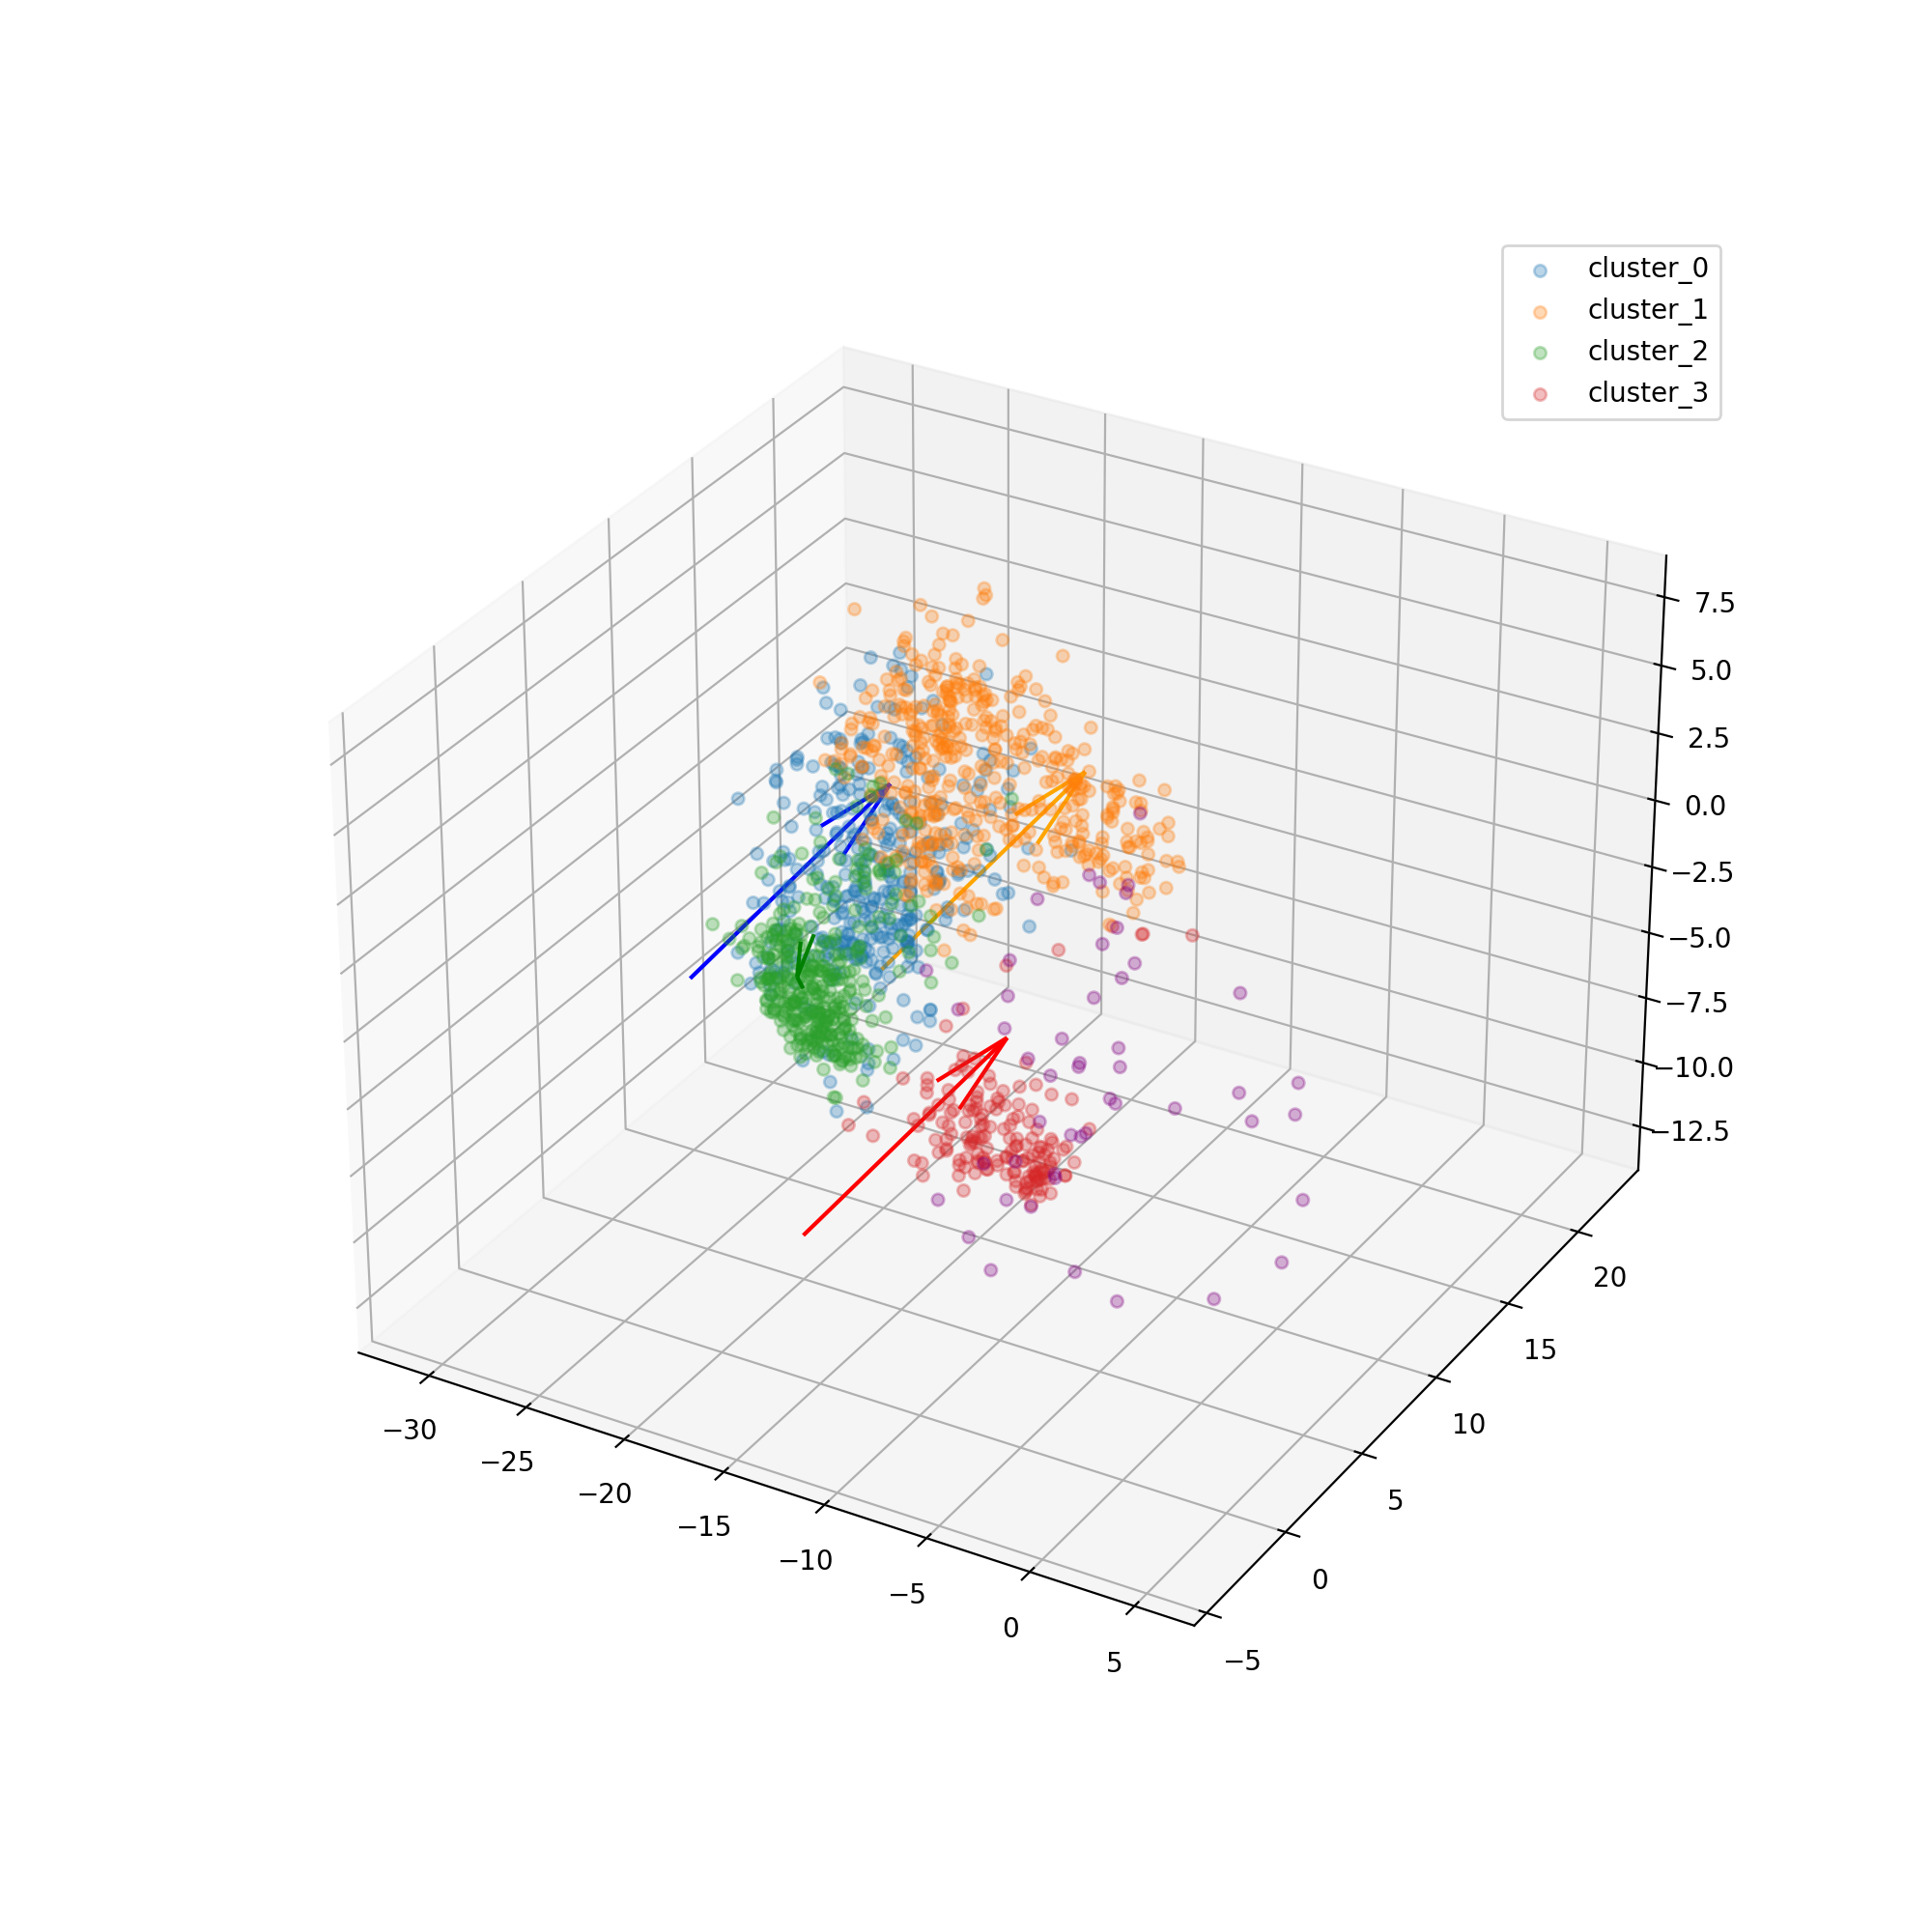

In [167]:
### Memorability changes by coordinates in each cluster
# normalized: highest R^2 (cluster 1) = 0.318
# mobius: highest R^2 (cluster 3) = 0.123

%matplotlib notebook

# plt.clf()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(cluster_0[0], cluster_0[1], cluster_0[2], label='cluster_0', alpha=0.3)
# ax.plot(np.linspace(-30,-20,100), np.linspace(10,20,100), -2.5+-.5+np.linspace(-30,-20,100)*.0057+ np.linspace(10,20,100)*.0509+ np.linspace(-7.5, 2.5, 100)*.0108, label='cluster_0', alpha=1)
# ax.plot(np.linspace(-15,-5,100), np.linspace(5,15,100), -.3135+np.linspace(-15,-5,100)*.1324+ np.linspace(5,15,100)*.1098+ np.linspace(-5, 5, 100)*-.0734, label='cluster_0', alpha=1)
ax.quiver(-30, 10, -7.5, 10, 10, 10, length = 10, normalize = True, color='blue')


# c0_grid = np.meshgrid(np.linspace(-20,-30,100), np.linspace(10,20,100))
# ax.plot_surface(c0_grid[0], c0_grid[1], -.5+X*.0057+ Y*.0509, label='cluster_0', alpha=1)

ax.scatter(cluster_1[0], cluster_1[1], cluster_1[2], label='cluster_1', alpha=0.3)
# ax.plot(np.linspace(-20,-10,100), np.linspace(10,20,100), .59+np.linspace(-20,-10,100)*.1288+ np.linspace(10,20,100)*.1266+ np.linspace(-5, 5, 100)*.0101, label='cluster_1', alpha=1)
# ax.plot(np.linspace(-20,-10,100), np.linspace(-2.5,7.5,100), -1.5349+np.linspace(-20,-10,100)*-.1115+ np.linspace(-2.5,7.5,100)*-.0823+ np.linspace(-5, 5, 100)*.0273, label='cluster_1', alpha=1)
ax.quiver(-20, 10, -5, 10, 10, 10, length = 10, normalize = True, color='orange')


# c1_grid = np.meshgrid(np.linspace(-10,-20,100), np.linspace(10,20,100))
# ax.plot_surface(c1_grid[0], c1_grid[1], .59+X*.1288+ Y*.1266, label='cluster_1', alpha=1)

ax.scatter(cluster_2[0], cluster_2[1], cluster_2[2], label='cluster_2', alpha=0.3)
# ax.plot(np.linspace(-25,-15,100), np.linspace(0,10,100), -.49+np.linspace(-25,-15,100)*-.0665+ np.linspace(0,10,100)*-.1488+ np.linspace(-7.5, 2.5, 100)*-.0007, label='cluster_2', alpha=1)
# ax.plot(np.linspace(-15,-5,100), np.linspace(10,0,100), 1.6519+np.linspace(-15,-5,100)*.1747+ np.linspace(10,0,100)*-.0601+ np.linspace(0, 10, 100)*.0127, label='cluster_2', alpha=1)
ax.quiver(-15, 0, 2.5, -10, 10, -10, length = 10, normalize = True, color='green')


# c2_grid = np.meshgrid(np.linspace(-25,-15,100), np.linspace(0,10,100))
# ax.plot_surface(c2_grid[0], c2_grid[1], -.49+X*-.0665+ Y*-.1488, label='cluster_2', alpha=1)

ax.scatter(cluster_3[0], cluster_3[1], cluster_3[2], label='cluster_3', alpha=0.3)
# ax.plot(np.linspace(-20,-10,100), np.linspace(5,15,100), -10+.47+np.linspace(-20,-10,100)*.1483+ np.linspace(5,15,100)*.1887+ np.linspace(-12.5, -7.5, 100)*.0244, label='cluster_3', alpha=1)
# ax.plot(np.linspace(-17.5,-7.5,100), np.linspace(10,0,100), 1.0544+np.linspace(-17.5,-7.5,100)*.1962+ np.linspace(10,0,100)*-.1758+ np.linspace(0, -10, 100)*.0596, label='cluster_3', alpha=1)
ax.quiver(-20, 5, -12.5, 10, 10, 10, length = 10, normalize = True, color='red')


# c3_grid = np.meshgrid(np.linspace(-10,-20,100), np.linspace(5,15,100))
# ax.plot_surface(c3_grid[0], c3_grid[1], .47+X*.1483+ Y*.1887, label='cluster_3', alpha=1)

ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='purple', alpha=.3)

plt.legend()


On cluster level, typicality and cartesian coordinates of concepts explained 3% more variance in memorability than coordinates alone. 

In [52]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.1836525405109798